# Model design

Two qubits that evolve with the same Lindbladian (or different ones, it can come in a jnp.array where the first axis is the number of components)

There should be a way of check errors in jax, but I do not know. Probably try catch before calling something with jit

I guess that the main loop can be done with jit, but before we could check that everything is correct. 

For now let's focus on writing things modular.

1. Write everything in row based vectorization to make it compatible with flat and reshape
2. Work as much as we can with vectorized version
3. 

In [1]:
import jax
import jax.numpy as jnp
from qdots_qll.models.game import *

import qutip as qt

import matplotlib.pyplot as plt

from qbism import sic_povm

import jax.typing

import equinox as eqx


from jax import Array

# from jax.typing import ArrayLike
from jaxtyping import Array, Float, Complex, Int

In [2]:
seed = 3
rho_ex = qt.rand_dm_ginibre(2, seed=seed)

In [3]:
class base_class_dimension(eqx.Module):
    d: int
    matrix_d: Float[Array, "d d"]
    positive_eps: Float

    def __init__(
        self,
        dimension: int,
    ) -> None:
        self.d = dimension
        self.matrix_d = jnp.ones([self.d, self.d])
        self.positive_eps = 1e-8

    @jit
    def vec(self, rho: Complex[Array, "d d"]) -> Complex[Array, "d**2"]:
        return rho.flatten()

    @jit
    def sprepost(
        self, A: Complex[Array, "d1 d2"], B: Complex[Array, "d3 d4"]
    ) -> Float[Array, "d1*d3 d2*d4"]:
        return jnp.kron(A, B.T)

    @jit
    def spre(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        d = A.shape[0]
        return self.sprepost(A, jnp.identity(d))

    @jit
    def spost(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        d = A.shape[0]

        return self.sprepost(jnp.identity(d), A)

In [4]:
check_nan = jax.jit(
    lambda a: jax.lax.cond(jnp.isnan(a), lambda a: 0.0, lambda a: a, a)
)


@jit
def compute_P_superop(
    evolved_state_vec: Complex[Array, "d**2"],
    POVM_element_vec: Complex[Array, "d**2"],
):

    return check_nan(
        jnp.real(jnp.dot(dag(POVM_element_vec), evolved_state_vec))
    )


@jit
def compute_P_matrix_ver(
    evolved_state: Complex[Array, "d d"],
    POVM_element: Complex[Array, "d d"],
):

    return check_nan(jnp.real(jnp.trace(evolved_state @ POVM_element)))


class single_qdot(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    system_hamiltonian: Complex[Array, "d d"]
    A: Complex[Array, "d d"]
    POVM_arr: Complex[Array, "no_outcomes d d"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes d d"]):
        super().__init__(dimension=2)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.system_hamiltonian = self.make_system_hamiltonian()
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_system_hamiltonian(self) -> Complex[Array, "d d"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "d**2 d**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "d**2 d**2"],
        initial_state: Complex[Array, "d**2"],
    ) -> Complex[Array, "d**2"]:
        return expm(t * liouvillian) @ initial_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_liouvillian(particle)
        evolved_state = self.evolve_initial_state_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_liouvillian(
                t, self.make_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

## Two qubits
The idea is the same, we can start with any initial state (of two qubits), but the map will be the following. For $\mathcal{L}$ being the Lindbladian for one dot, we represent $\Lambda$ as the map corresponding to $\exp{\mathcal{L}t}$. The total map is the product of both, as we assume that both dots do not interact: $\Lambda = \exp{\mathcal{L}t} \otimes \exp{\mathcal{L}t} $. Then we can check later in other notes how to do this properly with the indexes (the swapping thing).

Then we need to add some POVM, ofc.

Okay, this is not gonna be very general, but the dimension is 4, because $d=2^{n}$, where $n$ is the number of qubits. But we will need to remember that the dimension of each lindbladian is 2. 

In theory, I only have to change the lindbladian part and the evolution. 

In [117]:
check_nan = jax.jit(
    lambda a: jax.lax.cond(jnp.isnan(a), lambda a: 0.0, lambda a: a, a)
)


@jit
def compute_P_superop(
    evolved_state_vec: Complex[Array, "d**2"],
    POVM_element_vec: Complex[Array, "d**2"],
):

    return check_nan(
        jnp.real(jnp.dot(dag(POVM_element_vec), evolved_state_vec))
    )


@jit
def compute_P_matrix_ver(
    evolved_state: Complex[Array, "d d"],
    POVM_element: Complex[Array, "d d"],
):

    return check_nan(jnp.real(jnp.trace(evolved_state @ POVM_element)))


class two_qdots_separable_maps(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    one_dot_system_hamiltonian: Complex[Array, "2 2"]
    A: Complex[Array, "2 2"]
    POVM_arr: Complex[Array, "no_outcomes 4 4"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes 4 4"]):
        super().__init__(dimension=4)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.one_dot_system_hamiltonian = (
            self.make_one_dot_system_hamiltonian()
        )
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_one_dot_system_hamiltonian(self) -> Complex[Array, "2 2"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_one_dot_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "2**2 2**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.one_dot_system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.one_dot_system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_with_one_dot_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "2**2 2**2"],
        initial_state: Complex[Array, "4**2"],
    ) -> Complex[Array, "4**2"]:

        # This is the tricky part, we take the liouvillian, and then
        # we will apply both exp(L) to each qubit, carefully.
        # Remember the liouvillian is only for one dot

        map_A = expm(t * liouvillian)
        map_B = map_A

        total_map_superop = jnp.kron(
            map_A, map_B
        )  # this now is a superop in 16x16

        # Now the initial state needs to be reshape to 2, 2, 2, 2
        # swap the 2nd and 3d index.
        # vectorize
        # apply the total_map_superop
        # convert to 2, 2, 2, 2
        # unswap 2nd and 3rd
        # vectorize
        evolved_state = vec(
            (
                total_map_superop
                @ vec(
                    initial_state.reshape([2, 2, 2, 2])
                    .swapaxes(1, 2)
                    .reshape([4, 4])
                )
            )
            .reshape([2, 2, 2, 2])
            .swapaxes(1, 2)
            .reshape([4, 4])
        )

        return evolved_state

    # @jit
    # def evolve_initial_state_with_one_dot_liouvillian(
    #     self,
    #     t: Float,
    #     liouvillian: Complex[Array, "2**2 2**2"],
    #     initial_state: Complex[Array, "4**2"],
    # ) -> Complex[Array, "4**2"]:

    #     # This is the tricky part, we take the liouvillian, and then
    #     # we will apply both exp(L) to each qubit, carefully.
    #     # Remember the liouvillian is only for one dot

    #     map_A = expm(t * liouvillian)
    #     map_B = map_A

    #     total_map_superop = jnp.kron(
    #          jnp.identity(4), map_A
    #     )  # this now is a superop in 16x16

    #     # Now the initial state needs to be reshape to 2, 2, 2, 2
    #     # swap the 2nd and 3d index.
    #     # vectorize
    #     # apply the total_map_superop
    #     # convert to 2, 2, 2, 2
    #     # unswap 2nd and 3rd
    #     # vectorize
    #     evolved_state = vec(
    #         (
    #             total_map_superop
    #             @ vec(initial_state.reshape([2, 2, 2, 2]).swapaxes(1, 2).reshape([4, 4]))
    #         )
    #         .reshape([2, 2, 2, 2])
    #         .swapaxes(1, 2)
    #         .reshape([4, 4])
    #     )

    #     return evolved_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "4**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_one_dot_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_with_one_dot_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

    @jit
    def make_SLD(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        # eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(
            particle.astype(jnp.complex64)
        ).T  # first index is related to the parameter

        sld = jnp.einsum(
            "jk, ik -> ij",
            2
            * jnp.linalg.inv(
                jnp.kron(evolved_state, jnp.identity(d))
                + jnp.kron(
                    jnp.identity(d),
                    evolved_state,
                )
            ),
            partial_rhoi_parameterj,
        )

        return sld

In [91]:
class two_qdots_identity_for_systemB(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    one_dot_system_hamiltonian: Complex[Array, "2 2"]
    A: Complex[Array, "2 2"]
    POVM_arr: Complex[Array, "no_outcomes 4 4"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes 4 4"]):
        super().__init__(dimension=4)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.one_dot_system_hamiltonian = (
            self.make_one_dot_system_hamiltonian()
        )
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_one_dot_system_hamiltonian(self) -> Complex[Array, "2 2"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_one_dot_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "2**2 2**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.one_dot_system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.one_dot_system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_with_one_dot_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "2**2 2**2"],
        initial_state: Complex[Array, "4**2"],
    ) -> Complex[Array, "4**2"]:

        # This is the tricky part, we take the liouvillian, and then
        # we will apply both exp(L) to each qubit, carefully.
        # Remember the liouvillian is only for one dot

        map_A = expm(t * liouvillian)

        total_map_superop = jnp.kron(
            map_A, jnp.identity(4)
        )  # this now is a superop in 16x16

        # Now the initial state needs to be reshape to 2, 2, 2, 2
        # swap the 2nd and 3d index.
        # vectorize
        # apply the total_map_superop
        # convert to 2, 2, 2, 2
        # unswap 2nd and 3rd
        # vectorize
        evolved_state = vec(
            (
                total_map_superop
                @ vec(
                    initial_state.reshape([2, 2, 2, 2])
                    .swapaxes(1, 2)
                    .reshape([4, 4])
                )
            )
            .reshape([2, 2, 2, 2])
            .swapaxes(1, 2)
            .reshape([4, 4])
        )

        return evolved_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "4**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_one_dot_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_with_one_dot_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_one_dot_liouvillian(particle)
        evolved_state = self.evolve_initial_state_with_one_dot_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_with_one_dot_liouvillian(
                t, self.make_one_dot_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

In [15]:
povm1 = (
    jnp.array(
        [
            [0.5 * (qt.identity(2) + mat), 0.5 * (qt.identity(2) - mat)]
            for mat in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        ]
    ).reshape(-1, 2, 2)
    / 3
)

In [16]:
seed = 1

key = jax.random.PRNGKey(seed)

## Checking two dots works

In [17]:
from functools import reduce

In [18]:
list_ket_ii = [qt.tensor(qt.basis(2, i), qt.basis(2, i)) for i in range(2)]

ket_ii = reduce(lambda i, j: i + j, list_ket_ii).unit()

rho_omega_super = vec(
    qt.ket2dm(ket_ii).full()
)  # maximally entangled state (|omega><omega|)

In [19]:
# m = single_qdot(POVM_array=jnp.array(sic_povm(2)))
# m = single_qdot(POVM_array=povm1)
m = two_qdots_separable_maps(POVM_array=jnp.array(sic_povm(4)))

In [20]:
m

two_qdots_separable_maps(
  d=4,
  matrix_d=f32[4,4],
  positive_eps=1e-08,
  number_of_parameters=4,
  delta=0.12739334807998307,
  Omega=0.5,
  one_dot_system_hamiltonian=f32[2,2],
  A=i32[2,2],
  POVM_arr=c64[16,4,4],
  basis_elements=f32[4,4]
)

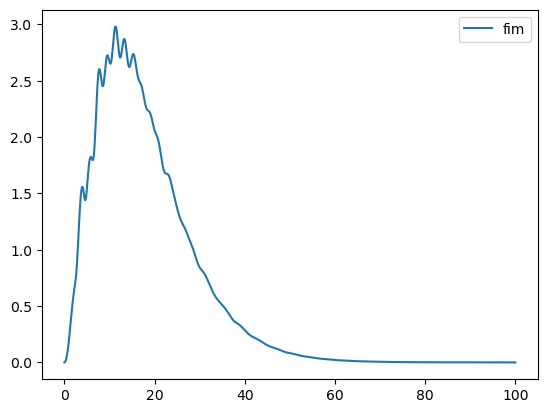

In [21]:
times = jnp.linspace(0, 100, 1000)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, rho_omega_super)
)(times)

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, rho_omega_super))(times)

evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, rho_omega_super))(
    times
)


plt.plot(times, evolution_fim[:, 2, 2], label="fim")
# plt.plot(times, evolution_qfim[:, 0, 0], label="qfim")


plt.legend()
plt.show()

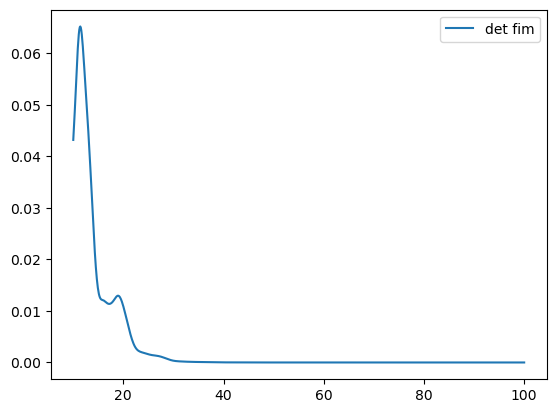

In [24]:
times = jnp.linspace(0, 100, 1000)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, rho_omega_super)
)(times)

evolution_det_fim = jax.vmap(
    lambda t: jnp.linalg.det(m.fim(true_pars, t, rho_omega_super))
)(times)

evolution_det_qfim = jax.vmap(
    lambda t: jnp.linalg.det(m.qfim(true_pars, t, rho_omega_super))
)(times)

# evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, rho_omega_super))(
#     times
# )


plt.plot(times[100:], evolution_det_fim[100:], label="det fim")
# plt.plot(times[100:], evolution_det_qfim[100:], label="det qfim")

# plt.plot(times, evolution_qfim[:, 0, 0], label="qfim")


plt.legend()
plt.show()

# Checking two qubits work correctly

In [69]:
simplest_povm_A = (
    jnp.array(
        [
            [0.5 * (qt.identity(2) + mat), 0.5 * (qt.identity(2) - mat)]
            for mat in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        ]
    ).reshape(-1, 2, 2)
    / 3
)

## Solution one dot

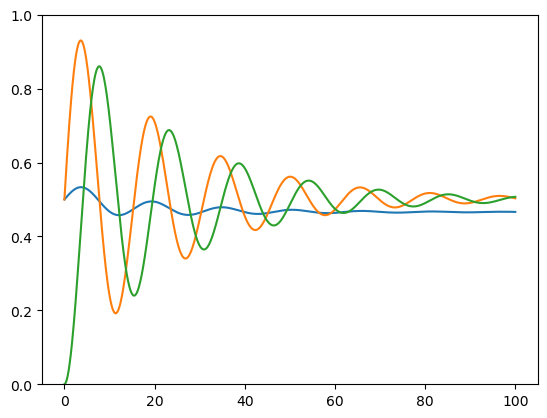

In [70]:
povm_x_axis = simplest_povm_A[0:2] * 3
povm_y_axis = simplest_povm_A[2:4] * 3
povm_z_axis = simplest_povm_A[4:] * 3


m = single_qdot(POVM_array=povm_x_axis)

initial_state = vec(qt.ket2dm(qt.basis(2, 1)).full())

times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

m = single_qdot(POVM_array=povm_y_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])


m = single_qdot(POVM_array=povm_z_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

plt.ylim(0, 1.0001)
plt.show()

# Completely separable case

1. Start with a separable state $ \otimes ^2\ket{0}\bra{0} $
2. The POVM is the tensor product of povm_1 and identity and the other way around (to check if both are correctly evolved)
3

## Checking free evolution system A

In [71]:
povm_A_id = jnp.array(
    [jnp.kron(i, jnp.identity(2)) for i in list(simplest_povm_A)]
)

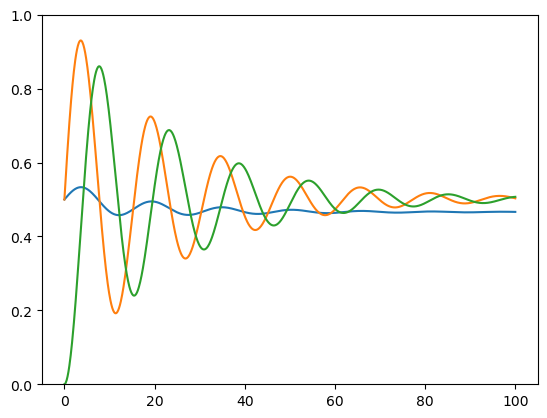

In [84]:
povm_A_x_axis = povm_A_id[0:2] * 3
povm_A_y_axis = povm_A_id[2:4] * 3
povm_A_z_axis = povm_A_id[4:] * 3


initial_state = vec(
    qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.basis(2, 1))).full()
)

m = two_qdots_separable_maps(POVM_array=povm_A_x_axis)


times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

m = two_qdots_separable_maps(POVM_array=povm_A_y_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])


m = two_qdots_separable_maps(POVM_array=povm_A_z_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

plt.ylim(0, 1.0001)
plt.show()

## Checking free evolution system B

In [85]:
povm_B_id = jnp.array(
    [jnp.kron(jnp.identity(2), i) for i in list(simplest_povm_A)]
)

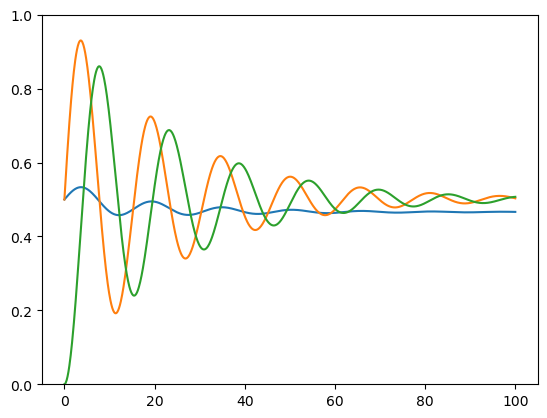

In [86]:
povm_A_x_axis = povm_A_id[0:2] * 3
povm_A_y_axis = povm_A_id[2:4] * 3
povm_A_z_axis = povm_A_id[4:] * 3


initial_state = vec(
    qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.basis(2, 1))).full()
)

m = two_qdots_separable_maps(POVM_array=povm_A_x_axis)


times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

m = two_qdots_separable_maps(POVM_array=povm_A_y_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])


m = two_qdots_separable_maps(POVM_array=povm_A_z_axis)


evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

plt.plot(times, evolved_lkl[:, 0])

plt.ylim(0, 1.0001)
plt.show()

# Choi case

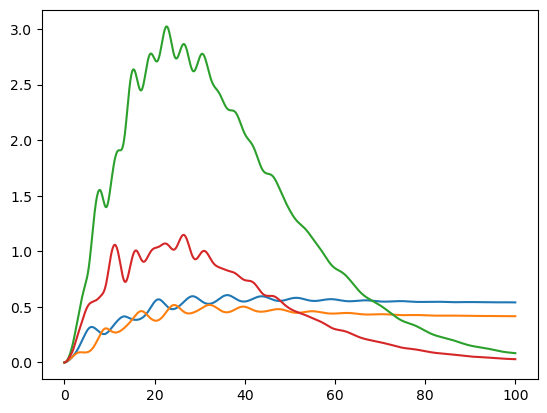

In [93]:
m = two_qdots_identity_for_systemB(POVM_array=jnp.array(sic_povm(4)))

initial_state = rho_omega_super

times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)


# plt.plot(times, evolved_lkl[:, 0])

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, initial_state))(times)

for i in range(4):
    plt.plot(times, evolution_fim[:, i, i])

plt.show()

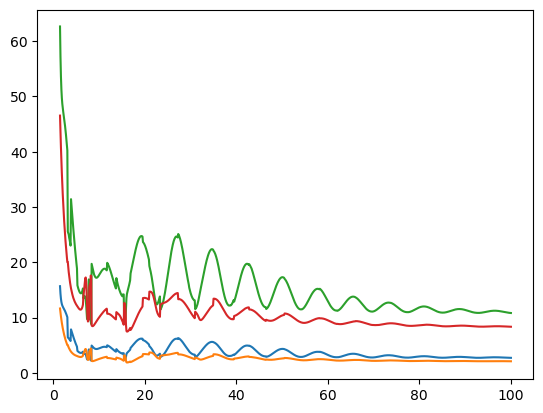

In [99]:
for i in range(4):
    plt.plot(times[15:], evolution_qfim[15:, i, i])

plt.show()

In [100]:
evolution_det_fim = jax.vmap(
    lambda t: jnp.linalg.det(m.fim(true_pars, t, initial_state))
)(times)

evolution_det_qfim = jax.vmap(
    lambda t: jnp.linalg.det(m.qfim(true_pars, t, initial_state))
)(times)

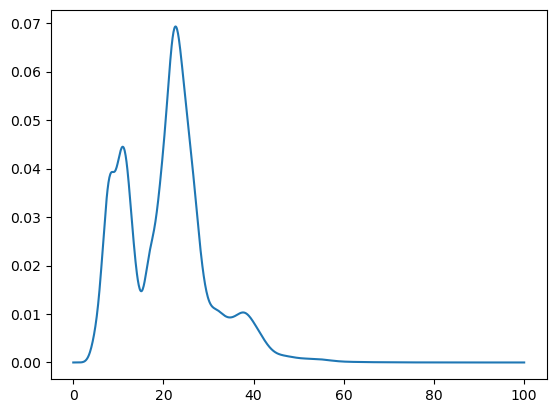

In [101]:
plt.plot(times, evolution_det_fim, label="det fim")

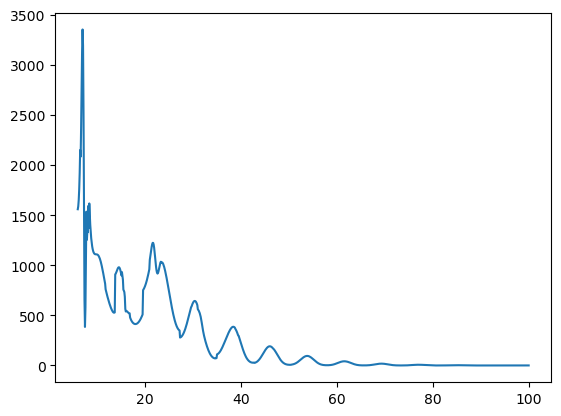

In [105]:
plt.plot(times[60:], evolution_det_qfim[60:], label="det qfim")

## Two dots separable (no choi)

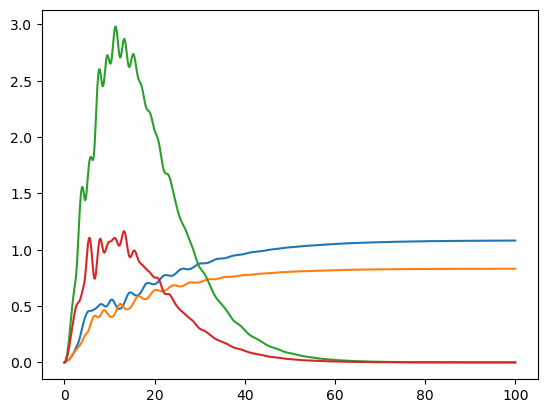

In [107]:
m = two_qdots_separable_maps(POVM_array=jnp.array(sic_povm(4)))

initial_state = rho_omega_super

times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)


# plt.plot(times, evolved_lkl[:, 0])

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, initial_state))(times)

for i in range(4):
    plt.plot(times, evolution_fim[:, i, i])

plt.show()

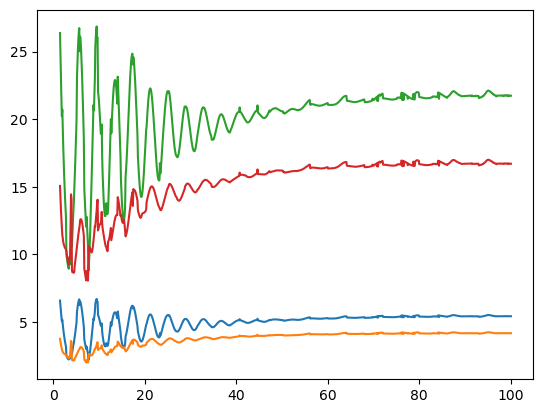

In [108]:
for i in range(4):
    plt.plot(times[15:], evolution_qfim[15:, i, i])

plt.show()

In [109]:
evolution_det_fim = jax.vmap(
    lambda t: jnp.linalg.det(m.fim(true_pars, t, initial_state))
)(times)

evolution_det_qfim = jax.vmap(
    lambda t: jnp.linalg.det(m.qfim(true_pars, t, initial_state))
)(times)

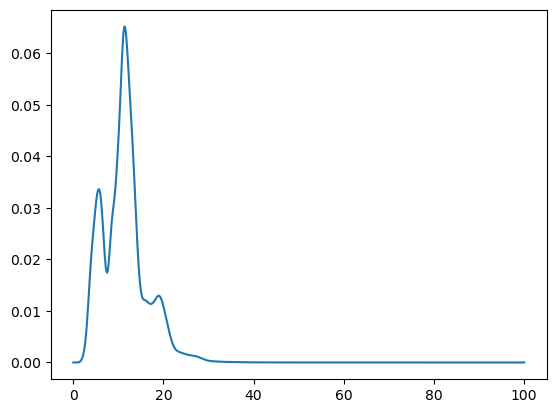

In [110]:
plt.plot(times, evolution_det_fim, label="det fim")

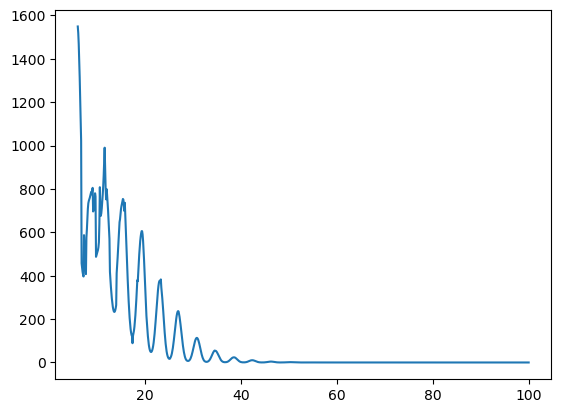

In [111]:
plt.plot(times[60:], evolution_det_qfim[60:], label="det qfim")

## Checking with local measurements

Now the measurements are gonna be the tensor products of two sic povm of dimension 2

In [113]:
jnp.array(sic_povm(2))

Array([[[ 0.39433756+0.j        ,  0.14433756+0.14433756j],
        [ 0.14433756-0.14433756j,  0.10566244+0.j        ]],

       [[ 0.39433756+0.j        , -0.14433756-0.14433756j],
        [-0.14433756+0.14433756j,  0.10566244+0.j        ]],

       [[ 0.10566244+0.j        ,  0.14433756-0.14433756j],
        [ 0.14433756+0.14433756j,  0.39433756+0.j        ]],

       [[ 0.10566244+0.j        , -0.14433756+0.14433756j],
        [-0.14433756-0.14433756j,  0.39433756+0.j        ]]],      dtype=complex64)

# Trying to engineer the sld

In theory, we can compute the sld in the superoperator form in this way:

2 (ρ ⊗ id + id ⊗ ρ )^−1 vec(∂a ρ).

In [120]:
m = two_qdots_separable_maps(POVM_array=jnp.array(sic_povm(4)))

initial_state = rho_omega_super

times = jnp.linspace(0, 100, 1000)

# evolved_lkl = jax.vmap(
#     lambda t: m.likelihood_particle(true_pars, t, initial_state)
# )(times)


# plt.plot(times, evolved_lkl[:, 0])

# evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

# evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, initial_state))(times)

# for i in range(4):
#     plt.plot(times, evolution_fim[:, i, i])

# plt.show()


sld_example = m.make_SLD(true_pars, times[50], initial_state)

In [126]:
jnp.linalg.eigh(sld_example[0].reshape([4, 4]))

(Array([-7.0931873,  1.1420983,  1.1632615,  7.1785717], dtype=float32),
 Array([[ 6.4576423e-01+1.0279666e-08j, -8.2162805e-06+3.4798663e-06j,
         -5.7434881e-01-4.8857128e-06j,  5.0310248e-01+6.2077570e-06j],
        [-5.1538843e-01-1.2888518e-08j,  7.0710415e-01+5.1801189e-06j,
         -1.8909793e-01-5.8632650e-06j,  4.4566864e-01+5.5388650e-06j],
        [-5.1538855e-01-2.1891303e-11j, -7.0710945e-01-2.8725924e-06j,
         -1.8907772e-01+2.7133233e-06j,  4.4566882e-01+5.5313244e-06j],
        [ 2.2746031e-01-1.1269468e-08j,  1.1072517e-05-4.6909245e-06j,
          7.7370220e-01+6.6798148e-06j,  5.9130943e-01+7.4274685e-06j]],      dtype=complex64))

In [125]:
sld_example[1].reshape([4, 4])

Array([[ 2.7503533 -5.478176j  , -3.0230334 -0.7867591j ,
        -3.0230331 -0.7867591j , -0.9040836 -4.82638j   ],
       [-3.0230334 -0.78675926j,  0.20420696+1.3368735j ,
        -0.6428133 +1.5381725j , -2.0130448 +0.73654807j],
       [-3.023034  -0.78675926j, -0.6428133 +1.5381725j ,
         0.20420682+1.336874j  , -2.0130448 +0.73654807j],
       [-0.90408355-4.8263793j , -2.013044  +0.7365483j ,
        -2.0130446 +0.73654824j, -1.6875979 -3.1661339j ]],      dtype=complex64)